# Generative linear models para ver tendencias de COVID-19 en Chile

In [232]:
#Cargamos datos
import pandas as pd

df = pd.read_excel('casos_n.xls').reset_index().rename(columns={1: 'new_cases', 'index': 'day'})
df['total_cases'] = df.new_cases.cumsum()
df

,day,new_cases,total_cases
0,0,2,2
1,1,1,3
2,2,1,4
3,3,1,5
4,4,2,7
5,5,3,10
6,6,6,16
7,7,5,21
8,8,11,32
9,9,10,42


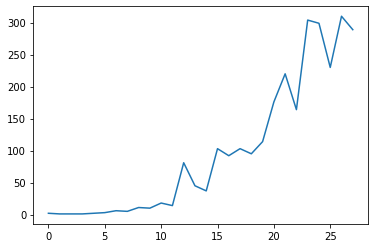

In [66]:
# Los miramos en el grafico
df.new_cases.plot()

In [233]:
from pygam import LinearGAM, s, f

# Definimos nuetras GAM como una linear de spline(X) + spline(X)
gam = LinearGAM(s(0) + s(0))

In [234]:
# Hacemos fit
X = np.expand_dims(df.day.to_numpy(), 1)
y = df.new_cases
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [235]:
# Un sumario

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.1272
Link Function:                     IdentityLink Log Likelihood:                                  -212.1259
Number of Samples:                           28 AIC:                                              442.5062
                                                AICc:                                             452.8495
                                                GCV:                                             1566.5623
                                                Scale:                                            777.8478
                                                Pseudo R-Squared:                                    0.951
Feature Function                  Lam

<ipython-input-235-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Ploteamos las predicciones para para el modelo y sus intervalos

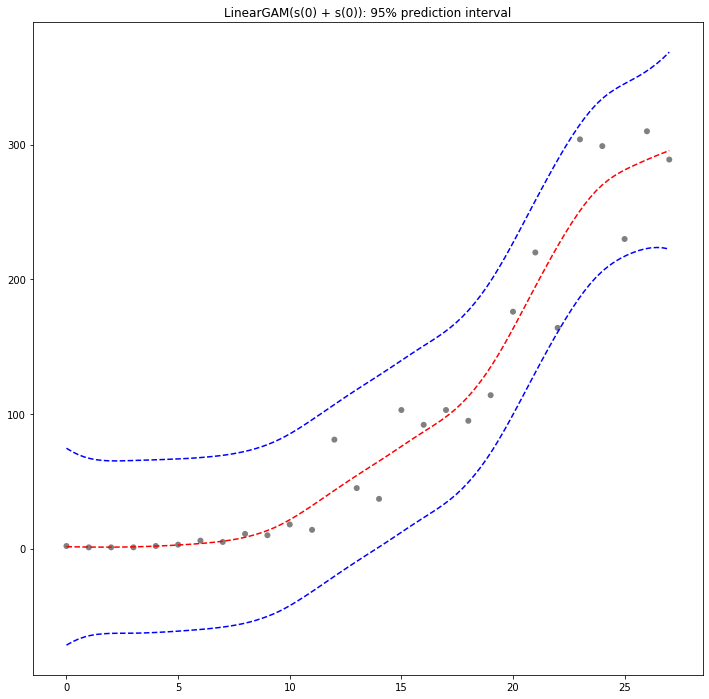

In [236]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12));

XX = gam.generate_X_grid(0)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX), color='b', ls='--')

plt.scatter(np.expand_dims(df.day.to_numpy(), 1), df.new_cases, facecolor='gray', edgecolors='none')
plt.title('LinearGAM(s(0) + s(0)): 95% prediction interval')
plt.savefig('LinearGAM(s(0) + s(0)): 95% prediction interval.png')

In [237]:
# Miremos los coeficientes
gam.coef_

array([-97.21975061, -97.77123722, -98.18299062, -97.9151746 ,
       -96.8138168 , -95.13516232, -91.82219341, -83.3872797 ,
       -66.16482731, -47.73786847, -31.31050243, -13.19718771,
         2.40167209,  34.12816377,  84.45137804, 134.00697618,
       172.38187048, 185.74294362, 196.69171775, 206.08639412,
        99.23312606])